#### Task 7: Support Vector Machines (SVM)

1. Imports & dataset (Breast Cancer from scikit-learn)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset (binary classification)
data = datasets.load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

print("Shape:", X.shape)
print("Classes (0=malignant, 1=benign) counts:\n", y.value_counts())

Shape: (569, 30)
Classes (0=malignant, 1=benign) counts:
 target
1    357
0    212
Name: count, dtype: int64


In [3]:
# Train / Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

2. Build pipelines (scaling + SVM) and train baseline models

In [4]:
# Linear SVM pipeline
pipe_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="linear", random_state=42))
])

In [5]:
# RBF SVM pipeline
pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", random_state=42))
])

In [6]:
# Fit both
pipe_linear.fit(X_train, y_train)
pipe_rbf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(random_state=42))])

In [8]:
# Evaluate (test set)
for name, model in [("Linear SVM", pipe_linear), ("RBF SVM", pipe_rbf)]:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    # Use decision_function for ROC-AUC (no need for probability=True)
    y_score = model.decision_function(X_test)
    auc = roc_auc_score(y_test, y_score)
    print(f"\n{name} | Test Accuracy: {acc:.4f} | ROC-AUC: {auc:.4f}")


Linear SVM | Test Accuracy: 0.9860 | ROC-AUC: 0.9973

RBF SVM | Test Accuracy: 0.9790 | ROC-AUC: 0.9969


3. 5-Fold Stratified Cross-Validation (baseline comparison)

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_report(pipe, X, y, name):
    acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy").mean()
    auc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc").mean()
    print(f"{name} | 5-fold CV Accuracy: {acc:.4f} | 5-fold CV ROC-AUC: {auc:.4f}")

cv_report(pipe_linear, X, y, "Linear SVM")
cv_report(pipe_rbf, X, y, "RBF SVM")

Linear SVM | 5-fold CV Accuracy: 0.9737 | 5-fold CV ROC-AUC: 0.9942
RBF SVM | 5-fold CV Accuracy: 0.9772 | 5-fold CV ROC-AUC: 0.9945


4. Hyperparameter Tuning (GridSearchCV)

In [10]:
# Grids (keep reasonable sizes to finish quickly)
param_grid_linear = {
    "clf__C": np.logspace(-3, 3, 7)   # 0.001 ... 1000
}

param_grid_rbf = {
    "clf__C": np.logspace(-2, 3, 6),  # 0.01 ... 1000
    "clf__gamma": np.logspace(-4, 1, 6)  # 1e-4 ... 10
}

grid_linear = GridSearchCV(
    pipe_linear, param_grid_linear, cv=cv, scoring="accuracy", n_jobs=-1
)
grid_rbf = GridSearchCV(
    pipe_rbf, param_grid_rbf, cv=cv, scoring="accuracy", n_jobs=-1
)

grid_linear.fit(X_train, y_train)
grid_rbf.fit(X_train, y_train)

print("Best Linear SVM:", grid_linear.best_params_, "| CV Acc:", grid_linear.best_score_)
print("Best RBF SVM:", grid_rbf.best_params_, "| CV Acc:", grid_rbf.best_score_)

best_linear = grid_linear.best_estimator_
best_rbf = grid_rbf.best_estimator_

Best Linear SVM: {'clf__C': np.float64(0.1)} | CV Acc: 0.9765526675786594
Best RBF SVM: {'clf__C': np.float64(10.0), 'clf__gamma': np.float64(0.001)} | CV Acc: 0.9741997264021889


5. Final evaluation on the test set (best models)


Best Linear SVM | Test Accuracy: 0.9860 | ROC-AUC: 0.9964

Classification Report:
               precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        53
      benign       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



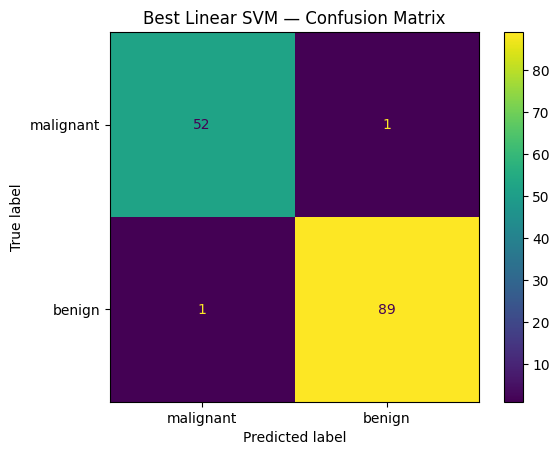


Best RBF SVM | Test Accuracy: 0.9790 | ROC-AUC: 0.9964

Classification Report:
               precision    recall  f1-score   support

   malignant       0.98      0.96      0.97        53
      benign       0.98      0.99      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



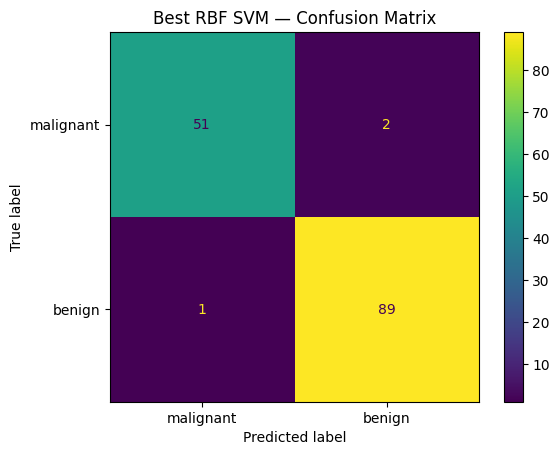

In [11]:
def eval_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    y_score = model.decision_function(X_test)
    auc = roc_auc_score(y_test, y_score)
    print(f"\n{title} | Test Accuracy: {acc:.4f} | ROC-AUC: {auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=data.target_names))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=data.target_names)
    disp.plot(values_format='d')
    plt.title(f"{title} — Confusion Matrix")
    plt.show()

eval_model(best_linear, X_test, y_test, "Best Linear SVM")
eval_model(best_rbf, X_test, y_test, "Best RBF SVM")

6. 2D Decision Boundary Visualization (PCA → 2 components)

We project features to 2D with PCA (for plotting only), train SVMs on the 2D data, and draw contours + support vectors.

In [12]:
# Prepare 2D data via PCA on TRAIN ONLY, then transform TEST
pca2 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=42))
])

X_train_2d = pca2.fit_transform(X_train)
X_test_2d  = pca2.transform(X_test)

In [13]:
# Refit SVMs on the 2D data using best hyperparameters
lin2d = SVC(kernel="linear", C=best_linear.get_params()["clf__C"], random_state=42)
rbf2d = SVC(kernel="rbf",
            C=best_rbf.get_params()["clf__C"],
            gamma=best_rbf.get_params()["clf__gamma"],
            random_state=42)

lin2d.fit(X_train_2d, y_train)
rbf2d.fit(X_train_2d, y_train)

SVC(C=np.float64(10.0), gamma=np.float64(0.001), random_state=42)

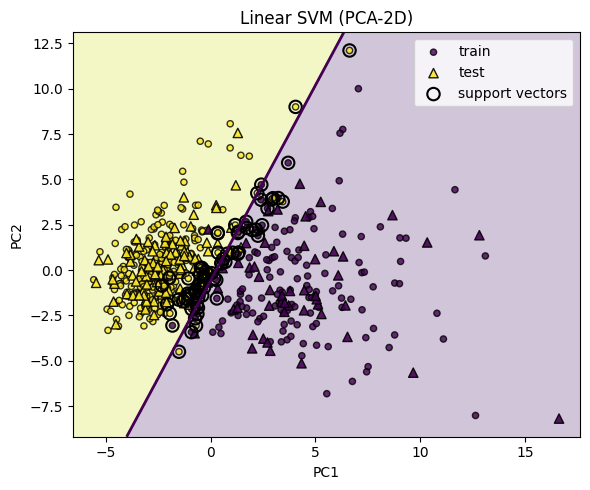

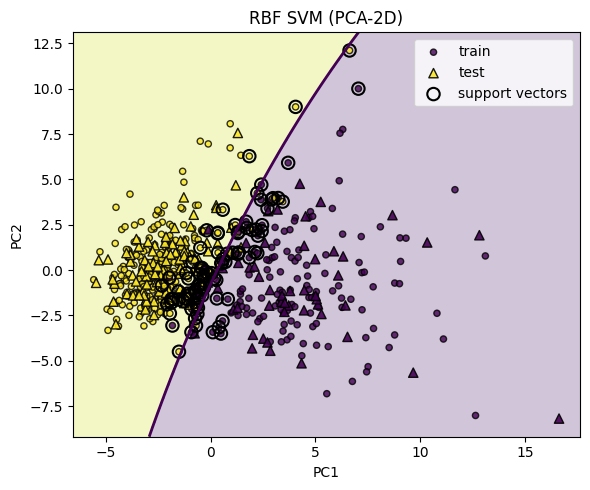

In [14]:
def plot_decision_boundary(clf, X_tr, y_tr, X_te, y_te, title):
    # Mesh grid
    x_min, x_max = np.r_[X_tr[:,0], X_te[:,0]].min()-1, np.r_[X_tr[:,0], X_te[:,0]].max()+1
    y_min, y_max = np.r_[X_tr[:,1], X_te[:,1]].min()-1, np.r_[X_tr[:,1], X_te[:,1]].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    # Training points
    plt.scatter(X_tr[:,0], X_tr[:,1], c=y_tr, s=20, edgecolor="k", alpha=0.8, label="train")
    # Test points
    plt.scatter(X_te[:,0], X_te[:,1], c=y_te, marker="^", s=45, edgecolor="k", alpha=0.9, label="test")
    # Support vectors (if available)
    if hasattr(clf, "support_vectors_"):
        sv = clf.support_vectors_
        plt.scatter(sv[:,0], sv[:,1], s=80, facecolors='none', edgecolors='k', linewidths=1.5, label="support vectors")

    # Decision boundary (level=0 of decision function)
    try:
        Zf = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        cs = plt.contour(xx, yy, Zf, levels=[0], linewidths=2)
        cs.collections[0].set_label("decision boundary")
        # Optional margins for linear
        if clf.kernel == "linear":
            plt.contour(xx, yy, Zf, levels=[-1, 1], linestyles="--")
    except Exception:
        pass

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

plot_decision_boundary(lin2d, X_train_2d, y_train, X_test_2d, y_test, "Linear SVM (PCA-2D)")
plot_decision_boundary(rbf2d, X_train_2d, y_train, X_test_2d, y_test, "RBF SVM (PCA-2D)")
